In [1]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class Config:
    #...general params:
    workdir : str = '../../results/jetclass_test'   
    device : str = 'cuda:0'
    multi_gpu : bool = False

    #...data params:
    path = ['/home/df630/CMB/data/JetClass/TTBar_000.root',
            '/home/df630/CMB/data/JetClass/TTBar_001.root',
            '/home/df630/CMB/data/JetClass/TTBar_002.root']
    source:  int = 'noise'
    target: str = 'tops'
    min_num_particles = 30
    max_num_particles = 30
    feature_continuous: List[str] = field(default_factory = lambda : ['part_pt_log', 'part_etarel', 'part_phirel'])
    feature_discrete: List[str] = field(default_factory = lambda : ['flavor', 'charge'])
    feature_context: List[str] = field(default_factory = lambda : [])

    # #...model params:
    model : str = 'transformer'
    num_attention_blocks : int = 1
    num_heads : int = 4
    dim_hidden : int = 128 
    dim_time_emb : int = 16
    dim_discrete_emb : int = 0
    time_embedding  : str = 'sinusoidal'       # 'sinusouidal' 'kolmogorov-arnold'
    attention_embedding = 'linear'           # 'linear' 'kolmogorov-arnold'
    dropout : float = 0.1
    activation : str = 'GELU'

    #...training params:
    batch_size : int = 128
    data_split_frac : List[float] = field(default_factory = lambda : [0.8, 0.2, 0.0])  # train / val / test 
    epochs: int = 20
    early_stopping : int = None
    min_epochs : int = None 
    print_epochs : int = None   
    num_workers : int = 0
    pin_memory: bool = False

    #...cfm params:
    dynamics : str = 'CFM'
    sigma: float = 0.001

    #...optimization & scheduler params:
    optimizer: str = 'Adam'
    lr : float = 2e-4
    weight_decay : float = 0.0
    optimizer_betas : List[float] = field(default_factory = lambda : [0.9, 0.999])
    optimizer_eps : float = 1e-8
    optimizer_amsgrad : bool = False
    gradient_clip : float = None
    scheduler: str = None
    scheduler_t_max: int = None
    scheduler_eta_min: float = None
    scheduler_gamma: float = None
    scheduler_step_size: int = None

    #...generation pipeline params:
    sampler : str = 'EulerSolver'
    solver = 'euler'
    num_timesteps : int = 100
    time_eps : float = 1e-3

    def __post_init__(self):
        self.data = self.source + '_to_' + self.target
        self.dim_continuous = len(self.feature_continuous)
        self.dim_discrete = len(self.feature_discrete) 
        self.dim_context = len(self.feature_context)
        if self.multi_gpu: self.device = 'cuda:0'
        if self.dim_discrete == 0: self.dim_discrete_emb = 0




In [2]:
from cmb.data.jetclass import JetClassDataClass
from cmb.dynamics.cfm import ConditionalFlowMatching

config = Config()
jets = JetClassDataClass(config, standardize=True, discrete_features=True)
dynamics = ConditionalFlowMatching(config)

2024-09-10 18:41:04.807990: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 18:41:04.852503: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 18:41:04.853224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 18:41:05.510601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
jets.target.continuous.shape, jets.target.discrete.shape

(torch.Size([294237, 30, 3]), torch.Size([294237, 30, 2]))

In [5]:
from cmb.models.trainers import CMBTrainer

parT = ParticleTransformer(config)
print(parT)
generative_model = CMBTrainer(dynamics, parT, jets)
generative_model.train()


ParticleTransformer(
  (particle_embedding): ParticleEmbedding(
    (time_embedding): Sequential(
      (0): SinusoidalPositionalEncoding()
      (1): Linear(in_features=16, out_features=16, bias=True)
    )
    (embedding): Linear(in_features=19, out_features=128, bias=True)
  )
  (particle_attention_blocks): ModuleList(
    (0): ParticleAttentionBlock(
      (layernorm_0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha_block): MultiHeadAttention(
        (k): Linear(in_features=128, out_features=128, bias=False)
        (q): Linear(in_features=128, out_features=128, bias=False)
        (v): Linear(in_features=128, out_features=128, bias=False)
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layernorm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layernorm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc_block): Sequential(
        (0): Linear(in

number of training parameters: 102931
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 235389, validation size: 58847, testing sizes: 0


epochs:   0%|          | 0/20 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


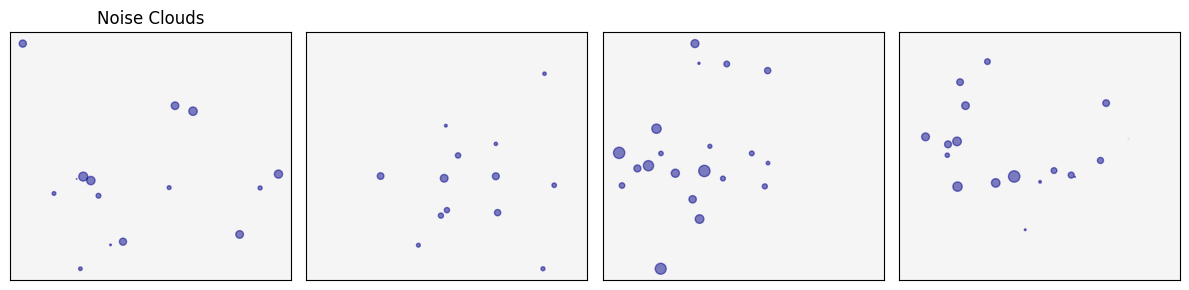

In [6]:
import matplotlib.pyplot as plt
from cmb.data.jetclass import ParticleClouds, NoiseClouds

noise = NoiseClouds(num_clouds=3000, max_num_particles=30, masks_like=jets.target)

fig, ax = plt.subplots(1, 4, figsize=(12,3)) 
noise.display_cloud(idx=0, ax=ax[0])
noise.display_cloud(idx=1, ax=ax[1])
noise.display_cloud(idx=2, ax=ax[2])
noise.display_cloud(idx=3, ax=ax[3])
ax[0].set_title('Noise Clouds')
plt.tight_layout()
plt.show()


In [8]:

pipeline = CFMPipeline(trained_model=generative_model, config=config)
# with torch.no_grad():
pipeline.generate_samples(noise)

INFO: EulerSolver with euler method and steps=100


In [9]:
pipeline.mask.shape

torch.Size([3000, 30])

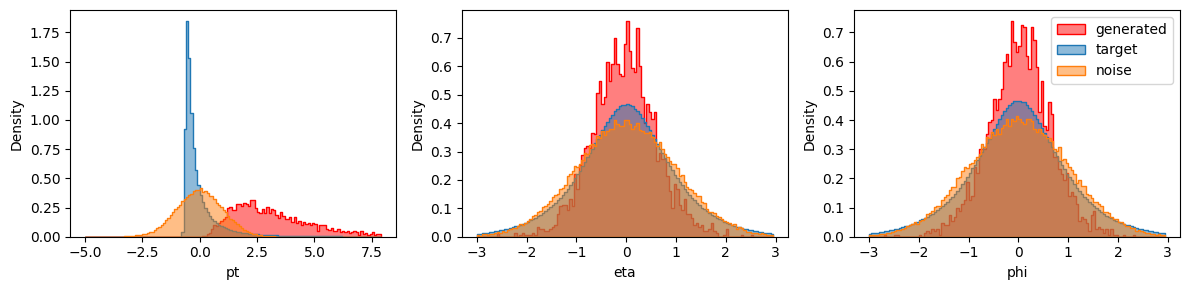

In [10]:
import seaborn as sns
import numpy as np

x1 = pipeline.trajectories

x_gen = x1.continuous.flatten(start_dim=1)
fig, ax = plt.subplots(1, 3, figsize=(12,3))

sns.histplot(x_gen[:,0],bins=np.arange(-5, 8,0.1), ax=ax[0], color='r', stat='density', element="step", alpha=0.5, label='generated')
jets.target.histplot('pt',bins=np.arange(-5, 8,0.1), ax=ax[0], stat='density', alpha=0.5, label='target')
noise.histplot('pt', bins=np.arange(-5, 8,0.1), ax=ax[0], stat='density', alpha=0.5, label='noise')

sns.histplot(x_gen[:,1], bins=np.arange(-3, 3,0.05), ax=ax[1], color='r', stat='density', element="step", alpha=0.5, label='generated')
jets.target.histplot('eta', bins=np.arange(-3, 3,0.05),ax=ax[1], stat='density', alpha=0.5, label='target')
noise.histplot('eta', bins=np.arange(-3, 3,0.05), ax=ax[1], stat='density', alpha=0.5, label='noise')

sns.histplot(x_gen[:,2], bins=np.arange(-3, 3,0.05), ax=ax[2], color='r', stat='density', element="step", alpha=0.5, label='generated')
jets.target.histplot('phi', bins=np.arange(-3, 3,0.05), ax=ax[2], stat='density', alpha=0.5, label='target')
noise.histplot('phi', bins=np.arange(-3, 3,0.05), ax=ax[2], stat='density', alpha=0.5, label='noise')
ax[2].legend()
plt.tight_layout()
plt.show()

In [14]:
jets = JetClassDataClass(config, discrete_features=True, standardize=True) 

/tmp/ipykernel_151827/2691141639.py:153: RuntimeWarning: invalid value encountered in log
  pt = np.log(1000 * self.pt[idx].numpy())
/tmp/ipykernel_151827/2691141639.py:284: RuntimeWarning: invalid value encountered in log
  pt = np.log(1000 * self.pt[idx].numpy())


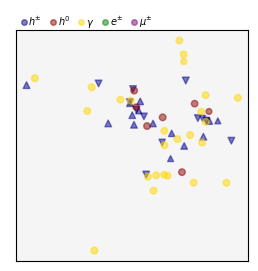

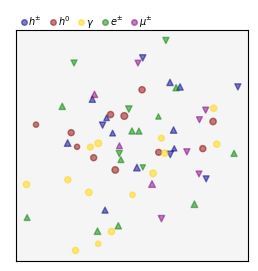

In [15]:
jets.target.display_cloud(idx=0)
jets.source.display_cloud(idx=0)

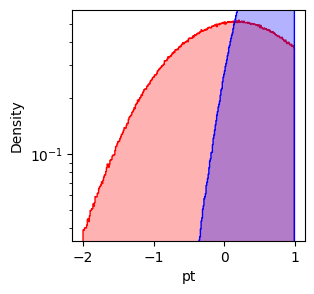

In [17]:
fig, ax = plt.subplots(figsize=(3,3))  
jets.target.histplot('pt', bins=np.arange(-2, 1,0.01), color='r', stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)
jets.source.histplot('pt', bins=np.arange(-2, 1,0.01), color='b', stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


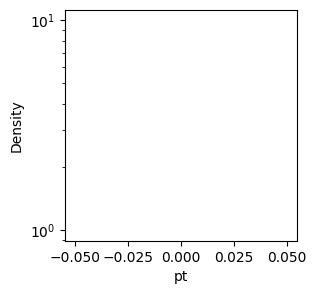

In [8]:
fig, ax = plt.subplots(figsize=(3,3))  
jets.source.histplot('pt', bins=np.arange(0, 1,0.01), color='b', idx=0, stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)
jets.target.histplot('pt', bins=np.arange(0, 1,0.01), color='r', idx=0, stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)

<Axes: ylabel='Count'>

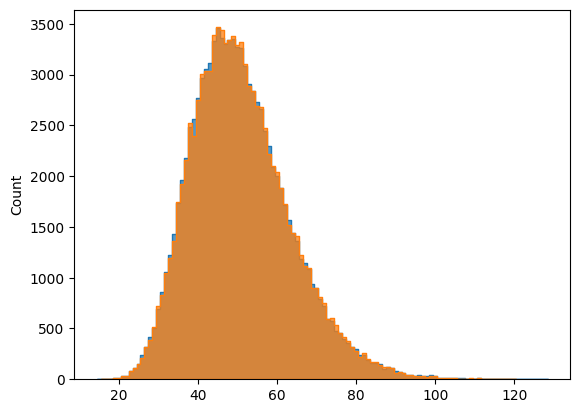

In [7]:
sns.histplot(jets.target.multiplicity, element='step', discrete=True)
sns.histplot(jets.source.multiplicity, element='step', discrete=True)